<a href="https://colab.research.google.com/github/kenchin138/DA-and-DS-Projects/blob/main/KM_CPH_Survival_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install requisite packages**

In [ ]:
%pip install lifelines -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 8.3 MB/s eta 0:00:00


# **Environment setup**

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test
from lifelines.utils import median_survival_times
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
pd.options.display.float_format = '{:,.3f}'.format
from lifelines.utils import k_fold_cross_validation

In [ ]:
pwd = os.getcwd()

# **Read property data**

This analysis will use data obtained from Zillow API. The dataset contains nationwide properties collected during a 1-month period starting from Feb 2015. Identifying information has been scrubbed out.

In [ ]:
file = pd.read_csv(pwd + '/US Housing Properties Feb 2015.csv', encoding='unicode_escape', low_memory=False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
file.head()

,property_url,property_id,address,street_name,apartment,city,state,latitude,longitude,postcode,price,censored_time_on_market,time_on_market,sold,facebook_advert,bedroom_number,bathroom_number,price_per_unit,living_space,land_space,land_space_unit,broker_id,property_type,property_status,year_build,total_num_units,agency_name,agent_name,agent_phone,is_owned_by_zillow
0,https://www.zillow.com/homedetails/1921-N-Rio-...,23591668,"1921 N Rio Grande Ln, Spokane Valley, WA 99016",N Rio Grande Ln,NaN,SPOKANE VALLEY,WA,47.677,-117.148,99016,"465,000.000",1,0,0,1,2.000,4.000,202.000,"2,299.000","7,712.000",sqft,NaN,SINGLE_FAMILY,SOLD,2014,NaN,Coldwell Banker Tomlinson S,NaN,NaN,0
1,https://www.zillow.com/homedetails/14611-E-13t...,23578670,"14611 E 13th Ave, Spokane Valley, WA 99037",E 13th Ave,NaN,SPOKANE VALLEY,WA,47.645,-117.208,99037,"389,900.000",1,0,0,1,2.000,4.000,234.000,"1,664.000",0.312,acres,NaN,SINGLE_FAMILY,SOLD,2005,NaN,Redfin,NaN,NaN,0
2,https://www.zillow.com/homedetails/52XX-E-Rive...,2064099048,"52XX E Riverville Ln, Chattaroy, WA 99003",X E Riverville Ln,NaN,CHATTAROY,WA,47.947,-117.339,99003,"1,250,000.000",1,0,0,1,3.000,4.000,369.000,"3,384.000",10.000,acres,NaN,SINGLE_FAMILY,FOR_SALE,2002,NaN,Keller Williams Spokane - Main,NaN,NaN,0
3,https://www.zillow.com/homedetails/13500-NE-11...,2067946069,"13500 NE 110th Ave, Vancouver, WA 98682",NE 110th Ave,NaN,VANCOUVER,WA,45.701,-122.532,98682,"549,000.000",1,0,0,1,3.000,3.000,309.000,"1,775.000",NaN,NaN,NaN,SINGLE_FAMILY,SOLD,2015,NaN,Pacific Lifestyle Homes,NaN,NaN,0
4,https://www.zillow.com/homedetails/20955-Yeoma...,71448426,"20955 Yeoman Rd, Bend, OR 97701",Yeoman Rd,NaN,BEND,OR,44.094,-121.276,97701,"799,000.000",1,0,0,1,3.000,4.000,278.000,"2,870.000","6,098.000",sqft,NaN,SINGLE_FAMILY,SOLD,1994,NaN,Keller Williams Realty C.O.,NaN,NaN,0


# **Filter relevant data and variables**
The goal will be to look at time-on-market at different levels of price.

Only single family property data for the Greater Houston Area (incl. Katy) are needed.

In [ ]:
filtered_data = file[((file['city'] == 'HOUSTON') | (file['city'] == 'THE WOODLANDS') | (file['city'] == 'SUGAR LAND')) & (file['state'] == 'TX') & (file['property_type'] == 'SINGLE_FAMILY')]


# **Data preprocessing**

*   Binary encoding property_status
*   Checking for NaN values
*   Checking for outliers
*   Categorizing price into levels





**Encoding pending as 1 for event and for_sale as 0 for censored event**


In [ ]:
dummy = pd.get_dummies(data = filtered_data['property_status'], drop_first=True).rename({'SOLD':'sale_status'}, axis=1)
filtered_data = pd.concat([filtered_data, dummy], axis = 1)

**Removing NaNs**

In [ ]:
data = filtered_data[['price', 'censored_time_on_market', 'sale_status']].copy()
data.isnull().sum()

price                      0
censored_time_on_market    0
sale_status                0
dtype: int64

In [ ]:
data = data.dropna()
data.describe()

,price,censored_time_on_market,sale_status
count,"8,143.000","8,143.000","8,143.000"
mean,"627,333.912",30.954,0.587
std,"1,046,161.416",16.267,0.492
min,0.000,1.000,0.000
25%,"279,900.000",17.000,0.000
50%,"382,500.000",32.000,1.000
75%,"599,000.000",44.000,1.000
max,"29,500,000.000",82.000,1.000


Looking at the summary statistics, there may be a few outliers that must be dealt with. Price also cannot be zero and will be removed.

**Removing zeros and outliers**

In [ ]:
data = data[data['price'] != 0]
data.describe()

,price,censored_time_on_market,sale_status
count,"8,142.000","8,142.000","8,142.000"
mean,"627,410.961",30.953,0.587
std,"1,046,202.561",16.267,0.492
min,"56,000.000",1.000,0.000
25%,"279,900.000",17.000,0.000
50%,"382,500.000",32.000,1.000
75%,"599,000.000",44.000,1.000
max,"29,500,000.000",82.000,1.000


In [ ]:
q1, q3 = np.percentile(data['price'], [25, 75])
iqr = q3 - q1
data = data[(data['price'] > q1 - (1.5*iqr)) & (data['price'] < q3 + (1.5*iqr))]

q1, q3 = np.percentile(data['censored_time_on_market'], [25, 75])
iqr = q3 - q1
data = data[(data['censored_time_on_market'] > q1 - (1.5*iqr)) & (data['censored_time_on_market'] < q3 + (1.5*iqr))]
data.describe()

,price,censored_time_on_market,sale_status
count,"7,263.000","7,263.000","7,263.000"
mean,"407,403.549",30.969,0.604
std,"192,926.678",16.361,0.489
min,"56,000.000",1.000,0.000
25%,"269,900.000",17.000,0.000
50%,"355,720.000",32.000,1.000
75%,"495,095.000",44.000,1.000
max,"1,075,000.000",82.000,1.000


**Divide price into levels**

In [ ]:
data['price_level'] = pd.qcut(data['price'], 3, ['1', '2', '3'])
data.head()

,price,censored_time_on_market,sale_status,price_level
4399,"371,000.000",1,1,2
4400,"172,500.000",1,1,1
4401,"459,000.000",1,1,3
4402,"525,000.000",1,1,3
4403,"625,000.000",1,1,3


In [ ]:
data.groupby('price_level').agg({'price': ['min', 'max', 'count']})


price                    
                    min           max count
price_level                                
1            56,000.000   299,000.000  2444
2           299,750.000   435,000.000  2421
3           435,190.000 1,075,000.000  2398

# **Kaplan-Meier Survival Analysis**




## **Fit Kaplan-Meier model**

In [ ]:
kmf = KaplanMeierFitter()
kmf.fit(data['censored_time_on_market'], data['sale_status'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7263 total observations, 2873 right-censored observations>

## **Functions**

In [ ]:
def logranksummary (data, col):
    logrank = pairwise_logrank_test(data['censored_time_on_market'], data[col], data['sale_status'])
    return logrank

def plot_kmf (data, col):
    t = data['censored_time_on_market']
    c = data['sale_status']
    plt.figure(1)
    data.sort_values('price_level')
    for r in data['price_level'].unique():
        tf = data['price_level'] == r
        kmf.fit(t[tf], c[tf] , label = r)
        categoryplot = kmf.plot(title='Kaplan-Meier Survival Curve by Price Level', ci_show=True)
        categoryplot.set_xlim([0.0, data['censored_time_on_market'].max() + 5])
        categoryplot.set_ylim([0.0, 1.0])
        plt.ylabel('Likelihood of remaining on the market')

def get_survprobs (data, col, val):
    t = data['censored_time_on_market']
    c = data['sale_status']
    tf = data[col] == val
    kmf.fit(t[tf], c[tf], label=val)
    probs = kmf.survival_function_at_times([7,14,21,28,35,42,49,56,64,71])
    return probs

## **Summarizing results**

**Overall Kaplan-Meier Survival Curve**

Text(0, 0.5, 'Likelihood of remaining on the market')

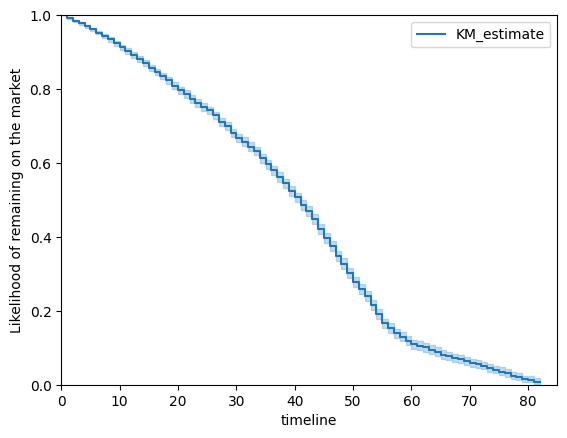

In [ ]:
overallplot = kmf.plot()
overallplot.set_xlim([0.0, 85.0])
overallplot.set_ylim([0.0, 1.0])
plt.ylabel('Likelihood of remaining on the market')

**Overall median survival time**

In [ ]:
kmf.median_survival_time_

41.0

**Log rank results for price level curves**

In [ ]:
data = data.sort_values('price_level')
logranksummary (data, 'price_level')

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
     test_statistic      p  -log2(p)
1 2           40.52 <0.005     32.26
  3           89.15 <0.005     67.89
2 3           11.04 <0.005     10.13

Each price group differ significantly from each other when it comes to a home being sold, represented by p-values less than the alpha set for this analysis (0.05). The next step is to get the numerical time-to-event probabilities (chance of staying on the market) for each group and then visualize the survival curves.


**Probability of staying on the market at 7-day week intervals for \$56,000 \$ to \$299,000 properties**


In [ ]:
get_survprobs (data, 'price_level', '1')

7    0.927
14   0.835
21   0.738
28   0.654
35   0.548
42   0.420
49   0.246
56   0.105
64   0.048
71   0.015
Name: 1, dtype: float64

**Probability of staying on the market at 7-day intervals for \$299,750 to \$435,000 properties**

In [ ]:
get_survprobs (data, 'price_level', '2')

7    0.951
14   0.874
21   0.794
28   0.711
35   0.599
42   0.472
49   0.316
56   0.177
64   0.119
71   0.091
Name: 2, dtype: float64

**Probability of staying on the market at 7-day intervals for \$435,190	to \$1,075,000 properties**

1.   List item
2.   List item



In [ ]:
get_survprobs (data, 'price_level', '3')

7    0.951
14   0.903
21   0.829
28   0.736
35   0.644
42   0.522
49   0.358
56   0.200
64   0.137
71   0.113
Name: 3, dtype: float64

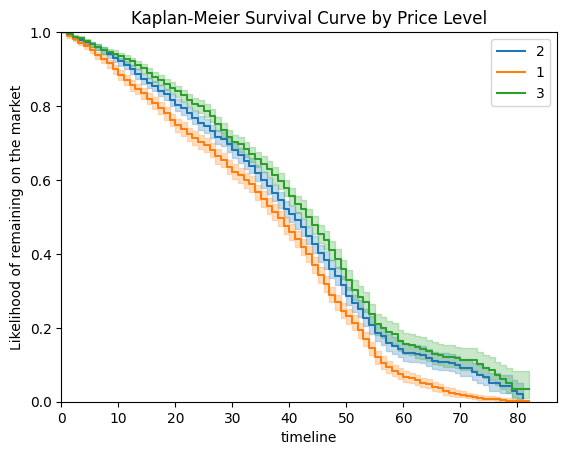

In [ ]:
plot_kmf (data, 'price_level')


Cheaper properties consistently have the lowest probability of staying on the market. At Day 30, probabilities begin to fall more rapidly until around Day 55. This could be due to more motivated sellers during this period or that poorly priced properties adjust their value to become more attractive to buyers around this time.



Probabilities of being on the market become relatively more stable after Day 55. Homes that have not sold by this point are less likely to be sold afterward. Probablities are notably different for cheaper properties during this period, while probabilities for medium and expensive properies are closer together. Sellers with homes on the market at this point may be lowering their valuation to the cheaper price level.



---


We can get further insight using a Cox Proportional Hazards model, which allows for multivariate analysis. Instead of measuring the probability of survival (staying on the market, in the real estate context), the Cox PH model measures the hazard rate, or rate of selling in this case.

Several property features will be included, such as the number of bedrooms, number of bathrooms, and the size of the property.

In [ ]:
data = filtered_data[['price', 'bedroom_number', 'bathroom_number', 'living_space', 'censored_time_on_market', 'sale_status']]
data.head()

,price,bedroom_number,bathroom_number,living_space,censored_time_on_market,sale_status
4399,"371,000.000",4.000,4.000,"2,924.000",1,1
4400,"172,500.000",1.000,3.000,"1,298.000",1,1
4401,"459,000.000",3.000,3.000,"2,151.000",1,1
4402,"525,000.000",3.000,3.000,"2,407.000",1,1
4403,"625,000.000",2.000,2.000,"1,743.000",1,1


## **Data preprocessing**

1. Checking for NaN values
2. Checking for zeros
3. Removing outliers
4. Standardizing the data

In [ ]:
data.isnull().sum()

price                       0
bedroom_number              0
bathroom_number            11
living_space               39
censored_time_on_market     0
sale_status                 0
dtype: int64

In [ ]:
data = data.dropna()
data.isnull().sum()

price                      0
bedroom_number             0
bathroom_number            0
living_space               0
censored_time_on_market    0
sale_status                0
dtype: int64

In [ ]:
data.describe()

,price,bedroom_number,bathroom_number,living_space,censored_time_on_market,sale_status
count,"8,100.000","8,100.000","8,100.000","8,100.000","8,100.000","8,100.000"
mean,"626,043.604",3.096,3.453,"2,481.052",30.944,0.588
std,"1,046,449.801",1.352,0.836,"1,561.268",16.262,0.492
min,"56,000.000",0.000,0.000,480.000,1.000,0.000
25%,"279,900.000",2.000,3.000,"1,662.000",17.000,0.000
50%,"382,750.000",3.000,3.000,"2,110.000",32.000,1.000
75%,"599,000.000",4.000,4.000,"2,812.250",44.000,1.000
max,"29,500,000.000",18.000,10.000,"37,132.000",82.000,1.000


In [ ]:
data = data[(data['price'] != 0) & (data['bedroom_number'] != 0) & (data['bathroom_number'] != 0) & (data['living_space'] != 0)]
data.shape

(8066, 6)

In [ ]:
cols = ['price', 'bedroom_number', 'bathroom_number', 'living_space']

q1 = data[cols].quantile(0.25)
q3 = data[cols].quantile(0.75)
iqr = q3 - q1
data = data[~((data[cols] < (q1 - 1.5 * iqr)) | (data[cols] > (q3 + 1.5 * iqr))).any(axis=1)] #any outliers will be set to true, then '~' sets them to false, then falses are filtered out
data.describe()


,price,bedroom_number,bathroom_number,living_space,censored_time_on_market,sale_status
count,"7,069.000","7,069.000","7,069.000","7,069.000","7,069.000","7,069.000"
mean,"403,013.667",2.813,3.332,"2,110.525",30.961,0.608
std,"188,286.277",0.913,0.652,704.972,16.332,0.488
min,"56,000.000",1.000,2.000,480.000,1.000,0.000
25%,"269,000.000",2.000,3.000,"1,620.000",17.000,0.000
50%,"354,900.000",3.000,3.000,"1,993.000",32.000,1.000
75%,"489,000.000",3.000,4.000,"2,518.000",44.000,1.000
max,"1,075,000.000",6.000,5.000,"4,528.000",82.000,1.000


**Standardizing price and size features**

In [ ]:
cols = ['price', 'living_space']
scale = StandardScaler()

data[cols] = scale.fit_transform(data[cols])
data.describe()

,price,bedroom_number,bathroom_number,living_space,censored_time_on_market,sale_status
count,"7,069.000","7,069.000","7,069.000","7,069.000","7,069.000","7,069.000"
mean,-0.000,2.813,3.332,-0.000,30.961,0.608
std,1.000,0.913,0.652,1.000,16.332,0.488
min,-1.843,1.000,2.000,-2.313,1.000,0.000
25%,-0.712,2.000,3.000,-0.696,17.000,0.000
50%,-0.256,3.000,3.000,-0.167,32.000,1.000
75%,0.457,3.000,4.000,0.578,44.000,1.000
max,3.569,6.000,5.000,3.429,82.000,1.000


# **Cox PH Analysis**

## **Fit Cox PH model**

In [ ]:
cox = CoxPHFitter(alpha = 0.05)
cox.fit(data, duration_col='censored_time_on_market', event_col='sale_status')

[0.5239662968866912, 0.5511947817101525, 0.5619921622779259, 0.5575094738815464, 0.5611519535381806, 0.5584780156373585, 0.5716912771902909, 0.5423978848953943, 0.5465684988985628, 0.5485328210902828]


<lifelines.CoxPHFitter: fitted with 7069 total observations, 2768 right-censored observations>

## **Summarizing Results**

Price, bedroom number, and living space are significant factors on the probability of sale, based on the p-values below 0.05.

A property that is **one standard deviation more expensive** ($177,184) is **0.81** times as likely to sell at any point in time compared to a property that is one standard deviation cheaper. However, a home that is **one standard deviation cheaper** is **1.23** times more likely to sell. Cheaper homes sell faster, which is consistent with the Kaplan-Meier price level curves.

Homes with more bedrooms also sell faster. A property with **one more bedroom** is **1.05** times as likely to sell at any given time. Properties with **one less bedroom** are **0.95** times as likely to sell.

At a given point in time, a property that is **one standard deviation larger in size** (625 sqft) is **1.08** times as likely to sell. Properties that are **one standard deviation smaller in size** are **0.93** times as likely to sell.

In [ ]:
cox.print_summary()

<lifelines.CoxPHFitter: fitted with 7069 total observations, 2768 right-censored observations>
             duration col = 'censored_time_on_market'
                event col = 'sale_status'
      baseline estimation = breslow
   number of observations = 7069
number of events observed = 4301
   partial log-likelihood = -33826.45
         time fit was run = 2023-06-17 07:54:03 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
price            -0.21       0.81       0.02            -0.26            -0.16                 0.77                 0.85
bedroom_number    0.05       1.05       0.02             0.00             0.09                 1.00                 1.10
bathroom_number  -0.02       0.98       0.03            -0.08             0.04                 0.92                 1.04
living_space      0.07       1.08       0.03             0.02             0.13                 1.02                 1.14

                  cmp to     z      p   -log2(p)
covariate                                       
price               0.00 -8.97 <0.005      61.56
bedroom_number      0.00  2.11   0.03       4.84
bathroom_number     0.00 -0.77   0.44       1.17
living_space        0.00  2.66   0.01       6.99
---
Concordance = 0.55
Partial AIC = 67660.89
log-likelihood ratio test = 95.14 on 4 df
-log2(p) of ll-ratio test = 63.03

In [ ]:
scores = k_fold_cross_validation(cox, data, 'censored_time_on_market', event_col='sale_status', k=5, scoring_method="concordance_index")
print (scores)

[0.5542695034076994, 0.5572207831936238, 0.5649032012604078, 0.5535628275043882, 0.5361223254102728]


<Axes: xlabel='HR (95% CI)'>

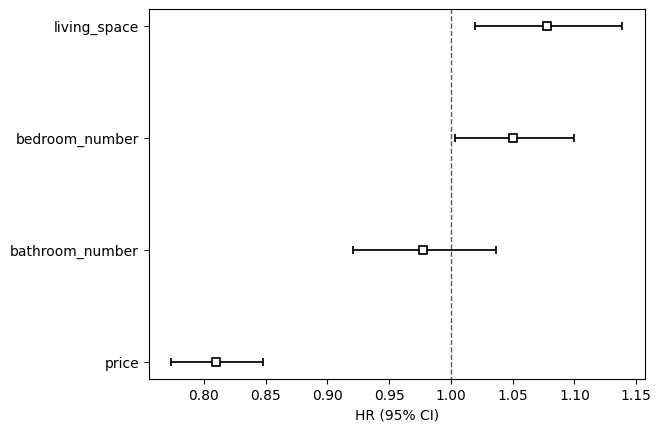

In [ ]:
cox.plot(hazard_ratios=True)

<Axes: >

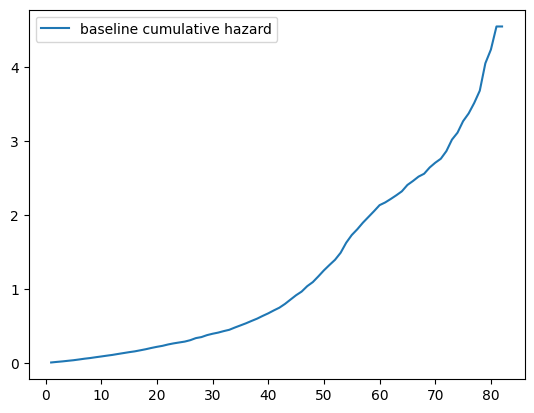

In [ ]:
cox.baseline_cumulative_hazard_.plot()

## **Checking Cox assumptions**
Before any conclusions are made, the results must meet the main Cox assumptions:

1.   The ratio of hazard rates for any two individuals stays constant over time
2.   Linearity of the features with the log hazard

These assumptions can be checked by running a Schoenfeld test and plotting the scaled Schoenfeld residuals. The assumption is met if the residuals do not deviate significantly from y = 0.



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.6662)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7897)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2113)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1187)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1117)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1273)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0397)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0410)'>]]

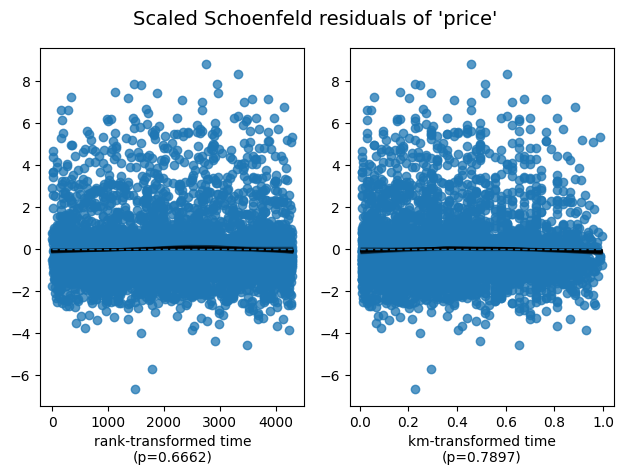

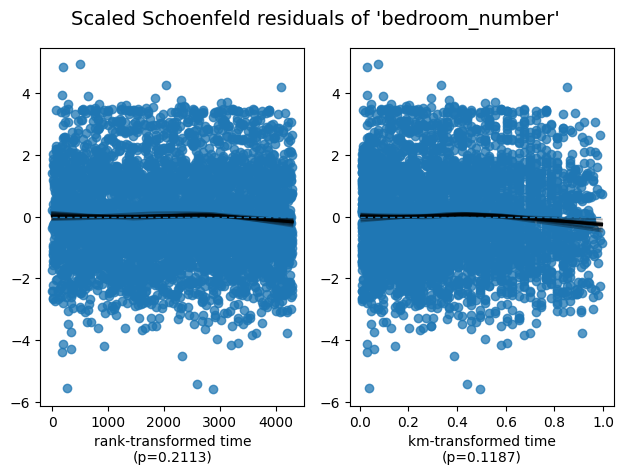

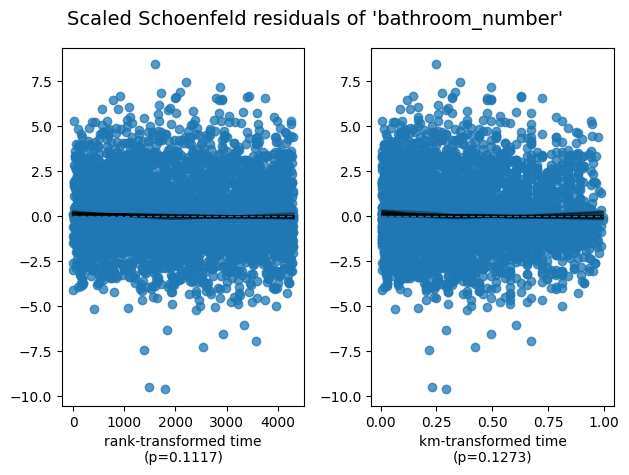

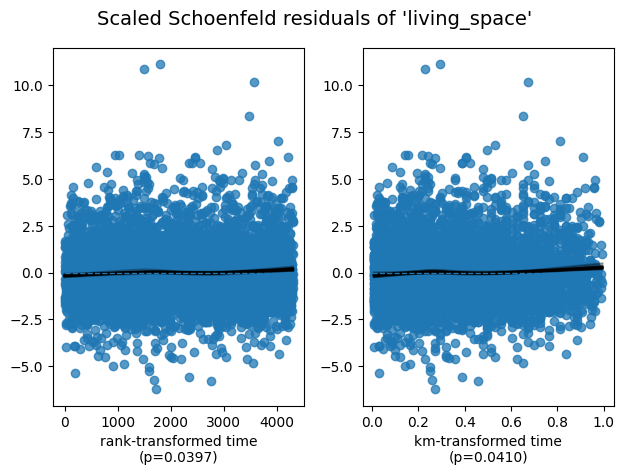

In [ ]:
cox.check_assumptions(data, 0.05, show_plots=True)

## **Limitations**

The Cox model, unlike linear regression models, does not calculate the intercept. As a result, Cox cannot directly estimate the hazard rate or survival rate. The model coefficients instead estimate the **hazard ratios**. This means that the coefficients tell how much more likely an event will occur for one group compared to another at a given point in time, assuming all other variables are constant.



This analysis provides a rather simplified model of factors affecting time to sale. In reality, transactions can fail, after which the home can be relisted or removed from the market altogther. This can happen for many reasons, usually related to financing or inspection issues. These issues would likely also affect the probability of sale. Additional features, variables, or interaction effects may improve model fit and would be worth exploring in the future.


Note that the results are representative of one month of data. Due to market fluctuations throughout the year, the survival times for other periods may be different. For example, the survival probabilities for properties during the winter season is likely to fall at a faster rate than this analysis suggests. If other periods are of interest, it is recommended to rerun the analysis with data from those periods.

# **End Notebook**